In [2]:
import numpy as np
import pandas as pd
import os
from Bio import SeqIO
import Bio
import Bio.PDB
import Bio.SeqRecord
from biopandas.pdb import PandasPdb
import pickle
from tqdm import tqdm
import os
import networkx as nx

In [3]:
data_path ="./data/raw/solo_representative_pdb_all__3_258/"
atomic_df = PandasPdb().read_pdb(data_path+"1A3M_1_A-B.pdb").df["ATOM"]
atomic_df["node_id"] = (
    atomic_df["chain_id"]
    + atomic_df["residue_number"].map(str)
    + atomic_df["residue_name"]
)
atomic_df


,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx,node_id
0,ATOM,1,,P,,G,,A,1,,...,17.441,-1.803,1.0,0.0,,A,P,NaN,20,A1G
1,ATOM,2,,C5',,G,,A,1,,...,17.439,0.590,1.0,0.0,,A,C,NaN,21,A1G
2,ATOM,3,,O5',,G,,A,1,,...,17.362,-0.837,1.0,0.0,,A,O,NaN,22,A1G
3,ATOM,4,,C4',,G,,A,1,,...,17.489,1.240,1.0,0.0,,A,C,NaN,23,A1G
4,ATOM,5,,O4',,G,,A,1,,...,18.643,0.780,1.0,0.0,,A,O,NaN,24,A1G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,ATOM,863,,H4',,C,,B,27,,...,18.371,-3.802,1.0,0.0,,B,H,NaN,883,B27C
863,ATOM,864,,H41,,C,,B,27,,...,18.640,-6.322,1.0,0.0,,B,H,NaN,884,B27C
864,ATOM,865,,H5',,C,,B,27,,...,16.523,-5.477,1.0,0.0,,B,H,NaN,885,B27C
865,ATOM,866,,H42,,C,,B,27,,...,18.275,-7.937,1.0,0.0,,B,H,NaN,886,B27C


In [4]:
import plotly.express as px
fig = px.scatter_3d(atomic_df, x='x_coord', y='y_coord', z='z_coord',
              symbol='element_symbol', color="node_id")
fig.update_traces(marker_size = 3)
fig.show()

In [6]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import os
from rich.progress import track
import torch
from sklearn.model_selection import train_test_split

def pdb2pandas(pdb_path):
    df = PandasPdb().read_pdb(pdb_path).df["ATOM"]
    df["node_id"] = (
        df["chain_id"]
        + df["residue_number"].map(str)
        + df["residue_name"]
    )
    return df


def create_pyg_datalist(data_path):
    max_pointcloud_size = 1233
    datalist = []
    shape_list = []
    # for filename in track(os.listdir(data_path), description="[cyan]Creating PyG Data from RNA pdb files"):
    for filename in tqdm(os.listdir(data_path), desc="Parsing Data from RNA pdb files"):
        if filename.endswith("pdb"):
            pdb_df = pdb2pandas(os.path.join(data_path, filename))
            coordinates = pdb_df[["x_coord","y_coord","z_coord"]].to_numpy()         # should be shape (num_atoms,3)
            atom_number = torch.from_numpy(pdb_df[["atom_number"]].to_numpy())
            node_id = pdb_df[["node_id"]].to_numpy()
            shape_list.append(coordinates.shape[0])
            if coordinates.shape[0] <= max_pointcloud_size:
                paddingamount = max_pointcloud_size - coordinates.shape[0]
                coords_padded = torch.from_numpy(np.pad(coordinates, ((0, paddingamount),(0, 0)), 'constant', constant_values=(0, 0))).type(torch.FloatTensor)    
                data = Data(pos=coords_padded, atom_number=atom_number, y=node_id, num_nodes=coords_padded.shape[0])
                datalist.append(data)

            # else:
            #     raise Exception("Incorrect max_pointcloud_size")
            
            


    return datalist, shape_list

data_list, shape_list = create_pyg_datalist(data_path=data_path)
pointcloud_size = 1233


            

Parsing Data from RNA pdb files: 100%|██████████| 943/943 [00:22<00:00, 41.29it/s]


In [7]:
X_train, X_test = train_test_split(data_list, test_size=0.3, random_state=42)
print(len(X_train),"+", len(X_test),"=", len(X_train) + len(X_test))
train_data_loader = DataLoader(X_train, batch_size=1)
test_data_loader = DataLoader(X_test, batch_size=1)

497 + 214 = 711


(711, 1233)

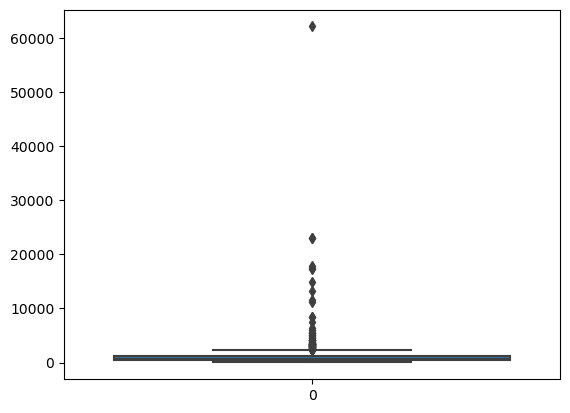

In [8]:
import seaborn as sns

sns.boxplot(shape_list)
shapes = np.array(shape_list)
mean = np.mean(shape_list)
len(shapes[shapes<=mean]), int(mean)


In [9]:
from torch_cluster import knn_graph
from torch_geometric.nn.conv import XConv,PPFConv        # PPF Conv is roto-translational equivariant
import torch.nn as nn
import torch

from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing



class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super().__init__(aggr='max')
        
        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(Linear(in_channels + 3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))
        
    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)
    
    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)
        print(input.shape)
        mess = self.mlp(input) 
        print(mess)
        return mess


class PointNetEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        
    def forward(self, pos, batch):
        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
        
        # 3. Start bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        return h

class XConvEncoder(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, kernel_size=10):
        super().__init__()

        torch.manual_seed(12345)
        
        self.conv1 = XConv(num_features,hidden_dim, dim=num_features, kernel_size= kernel_size, hidden_channels= num_features)
        self.conv2 = XConv(hidden_dim,hidden_dim, dim=num_features, kernel_size= kernel_size, hidden_channels= num_features)
        # self.conv2 = XConv(hidden_dim,hidden_dim, dim=num_features, kernel_size= kernel_size, hidden_channels= num_features)
        # self.conv2 = XConv(hidden_dim,hidden_dim, dim=num_features, kernel_size= kernel_size, hidden_channels= num_features)
        # self.conv2 = XConv(hidden_dim,hidden_dim, dim=num_features, kernel_size= kernel_size, hidden_channels= num_features)

        
    def forward(self, pos, batch):
        x = self.conv1(x=pos, pos=pos, batch=batch)
        x = x.relu()
        x = self.conv2(x=x, pos=pos, batch=batch)
        return x


class XConvDecoder(torch.nn.Module):
    def __init__(self, input_dim, out_features):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = XConv(input_dim, input_dim, dim=input_dim, kernel_size= 5, hidden_channels= input_dim)
        self.conv2 = XConv(input_dim,out_features, dim=input_dim, kernel_size= 5, hidden_channels= out_features)
        
    def forward(self, pos, batch):
        x = self.conv1(x=pos, pos=pos, batch=batch)
        x = x.relu()
        x = self.conv2(x=x, pos=pos,  batch=batch)
        return x
    
    
class LinearDecoder(torch.nn.Module):
    def __init__(self, input_dim, out_features, hidden_dim=16):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, out_features)

        
    def forward(self, z):
        x_ = self.linear1(z).relu()
        x_ = self.linear2(x_).relu()
        x_ = self.linear3(x_).relu()
        x_ = self.linear4(x_)
        return x_
        

class PointAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
 
    def forward(self, pos, batch):
        encoded = self.encoder(pos, batch)
        decoded = self.decoder(encoded, batch)
        return decoded
    
    


class XConvAutoEncoder(torch.nn.Module):
    def __init__(self, num_features, num_points, hidden_dim=128, kernel_size=10):
        super().__init__()

        torch.manual_seed(12345)
        # self.encoder = nn.Sequential(
        #     XConv(num_features, 64, dim=3, kernel_size=10, hidden_channels=3),
        #     nn.ReLU(inplace=True),
        #     XConv(64, 128, dim=3, kernel_size=10, hidden_channels=3),
        #     nn.ReLU(inplace=True),
        #     XConv(128, 128, dim=3, kernel_size=10, hidden_channels=3),
        #     nn.ReLU(inplace=True),
        #     XConv(128, 256, dim=3, kernel_size=10, hidden_channels=3),
        # )
        self.conv1 = XConv(num_features, 64, dim=3, kernel_size=10, hidden_channels=3)
        self.conv2 = XConv(64, 128, dim=3, kernel_size=10, hidden_channels=3)
        self.conv3 = XConv(128, 128, dim=3, kernel_size=10, hidden_channels=3)
        self.conv4 = XConv(128, 256, dim=3, kernel_size=10, hidden_channels=3)
        self.conv5 = XConv(256, hidden_dim, dim=3, kernel_size=10, hidden_channels=3)

        self.pooling = nn.AdaptiveMaxPool1d(1)
        
        self.decoder = nn.Sequential(
            nn.Conv1d(hidden_dim, 256, kernel_size=1, bias=False),
            # nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=1, bias=False),
            # nn.BatchNorm1d(256),
            nn.Conv1d(256, num_points * 3, kernel_size=1)
        )
        
        
    def forward(self, pos, batch):
        num_points = pos.shape[0]
        x = self.conv1(x=pos, pos=pos, batch=batch).relu()
        x = self.conv2(x=x, pos=pos, batch=batch).relu()
        x = self.conv3(x=x, pos=pos, batch=batch).relu()
        x = self.conv4(x=x, pos=pos, batch=batch).relu()
        x = self.conv5(x=x, pos=pos, batch=batch)
        encoding = self.pooling(x.T)  # shape [b, k, 1]
        decoded = self.decoder(encoding)
        restoration = decoded.view(3, num_points)

        # x = self.decoder(encoding)  # shape [b, num_points * 3, 1]
        # restoration = x.view(b, 3, num_points)

        return restoration.T
    
    
class LinearPointAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
 
    def forward(self, pos, batch):
        z = self.encode(pos, batch)
        x_ = self.decode(z)
        return x_
    
    def encode(self, pos, batch):
        encoded = self.encoder(pos, batch)
        return encoded
    
    def decode(self, encoded):
        decoded = self.decoder(encoded)
        return decoded


In [10]:
class Autoencoder(nn.Module):

    def __init__(self, k, num_points):
        """
        Arguments:
            k: an integer, dimension of the representation vector.
            num_points: an integer.
        """
        super(Autoencoder, self).__init__()

        # ENCODER

        pointwise_layers = []
        num_units = [3, 64, 128, 128, 256, k]

        for n, m in zip(num_units[:-1], num_units[1:]):
            pointwise_layers.extend([
                nn.Conv1d(n, m, kernel_size=1, bias=False),
                nn.BatchNorm1d(m),
                nn.ReLU(inplace=True)
            ])

        self.pointwise_layers = nn.Sequential(*pointwise_layers)
        self.pooling = nn.AdaptiveMaxPool1d(1)

        # DECODER

        self.decoder = nn.Sequential(
            nn.Conv1d(k, 256, kernel_size=1, bias=False),
            # nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=1, bias=False),
            # nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, num_points * 3, kernel_size=1)
        )

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, 3, num_points].
        Returns:
            encoding: a float tensor with shape [b, k].
            restoration: a float tensor with shape [b, 3, num_points].
        """
        x = x.unsqueeze(0)
        x = torch.permute(x, (0, 2, 1))
        b, _, num_points = x.size()
        x = self.pointwise_layers(x)  # shape [b, k, num_points]
        encoding = self.pooling(x)  # shape [b, k, 1]

        x = self.decoder(encoding)  # shape [b, num_points * 3, 1]
        restoration = x.view(b, num_points, 3)

        return encoding, restoration

In [11]:
# encoder = XConvEncoder(3, 1)
# # encoder = PointNetEncoder()
# decoder = XConvDecoder(1, 3)
# # decoder = LinearDecoder(3, 3, 3)
# # model = PointAutoEncoder(encoder=encoder, decoder=decoder)
# model = PointAutoEncoder(encoder=encoder, decoder=decoder)

# model = XConvAutoEncoder(3,1233)
model = Autoencoder(128, 1233)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
from chamferdist import ChamferDistance
criterion = ChamferDistance()




In [12]:
import wandb
wandb.init(project="DiffRNAFold", entity="diffrnafold")

def train(model, optimizer, loader, epochs):
    model.train()
    
    total_loss = 0
    for epoch in range(epochs):
        epoch_loss = 0
        with tqdm(loader) as tepoch:
            for data in tepoch:
                tepoch.set_description(f"Epoch: {epoch}")
                optimizer.zero_grad()  # Clear gradients.
                # reconstructed = model(data.pos, data.batch)  # Forward pass.
                _,reconstructed = model(data.pos)
                loss = criterion(reconstructed, data.pos.unsqueeze(0))
                loss.backward()  # Backward pass.
                optimizer.step()  # Update model parameters.
                tepoch.set_postfix(loss=loss.item())
        wandb.log({"epoch": epoch, "epoch_loss": epoch_loss})


train(model, optimizer, train_data_loader,1000)

Epoch: 35:  95%|█████████▍| 471/497 [00:20<00:01, 23.38it/s, loss=4.25e-7]


KeyboardInterrupt: 

In [ ]:
for data in test_data_loader:
    _ , reconstructed = model(data.pos)
    
